# Assignment Set 8
by **Amir Mehrpanah** for Deep Learing Course at Data Science Center, SBU



## Preprocessing

In [ ]:
#@title Reading The Data
df = pd.read_csv('data/HRDataset.csv').drop(columns=['Employee_Name',
                                                     'ManagerName',
                                                     'Zip',
                                                     'Position',
                                                     'MaritalDesc',
                                                     'MarriedID',
                                                     'Sex',
                                                     'State',
                                                     'PerformanceScore',
                                                     'Department',
                                                     'EmploymentStatus',
                                                     'DaysLateLast30', # too many nulls
                                                     'LastPerformanceReview_Date', # too many nulls
                                                     'EmpID'])

In [ ]:
#@title Cleaning Data

# remove that yellow part!
cleandf = df.dropna(how='all')

# just one case in TermReason column majority imputing method
cleandf['TermReason'][3] = 'N/A - still employed'

# TermReason to TermReasonID
cleandf['TermReasonID'] = cleandf.pop('TermReason').astype('category').cat.codes

# HispanicLatino to category
cleandf['HispanicLatino'] =cleandf['HispanicLatino'].astype('category').cat.codes

# CitizenDesc to CitizenID
cleandf['CitizenID'] = cleandf.pop('CitizenDesc').astype('category').cat.codes

# RaceDesc to RaceID
cleandf['RaceID'] = cleandf.pop('RaceDesc').astype('category').cat.codes

# RecruitmentSource to RecruitmentSourceID
cleandf['RcrtmtSrcID'] = cleandf.pop('RecruitmentSource').astype('category').cat.codes

# dropping null ManagerID's
cleandf = cleandf.dropna(subset=['ManagerID'])

# DOB to Age
temp = cleandf.pop('DOB').str.replace(r'(\d+\/\d+)\/(\d+)', r'\1/19\2')
cleandf['Age'] = pd.to_datetime(temp, format='%m/%d/%Y')
cleandf['Age'] = (pd.to_datetime('today') - cleandf['Age']).dt.days

# DateofHire to Experience
cleandf['Experience'] =  pd.to_datetime(cleandf.pop('DateofHire'), format='%m/%d/%Y')
cleandf['Experience'] =  (max(cleandf['Experience']) - cleandf['Experience']).dt.days

# there are many null values
cleandf = cleandf.drop(columns='DateofTermination')

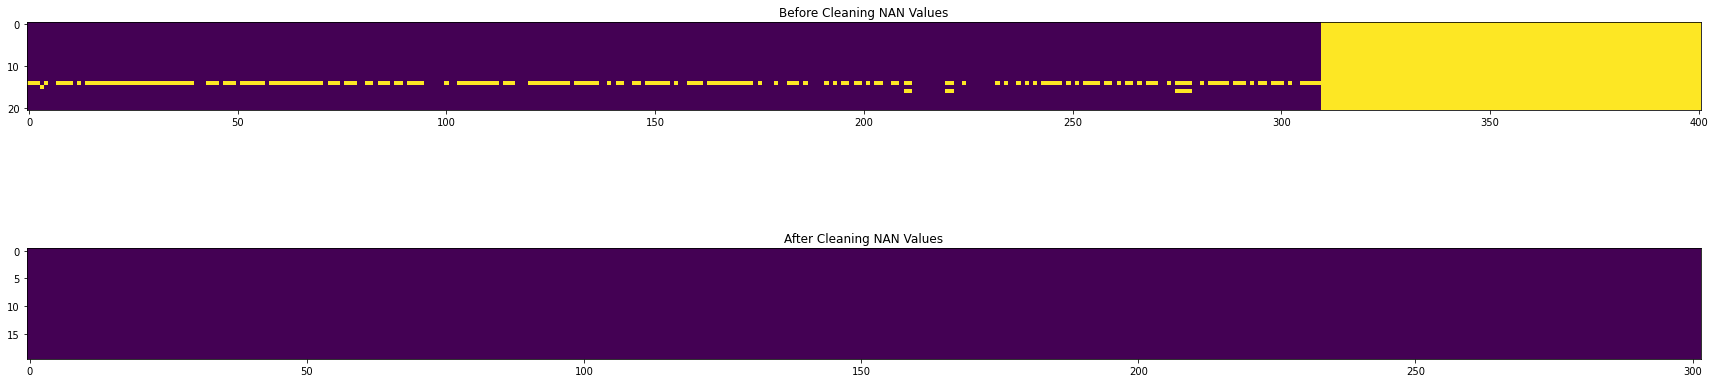

In [ ]:
#@title Visualizing NAN Values

plt.figure(figsize=(30,8))

ax = plt.subplot(2,1,1)
ax.set_title('Before Cleaning NAN Values')
plt.imshow(np.array(df.isnull()).T)

ax = plt.subplot(2,1,2)
ax.set_title('After Cleaning NAN Values')

plt.imshow(np.array(cleandf.isnull()).T)
plt.show()

In [ ]:
#@title OneHot Encoding 
X = cleandf.copy()
onehot_encoding_cols=['MaritalStatusID',
                      'EmpStatusID',
                      'DeptID',
                      'PositionID',
                      'ManagerID',
                      'TermReasonID',
                      'CitizenID',
                      'RaceID',
                      'RcrtmtSrcID']

for item in onehot_encoding_cols:
    temp = pd.get_dummies(X.pop(item), drop_first=True)
    X = pd.concat([temp,X],axis=1)

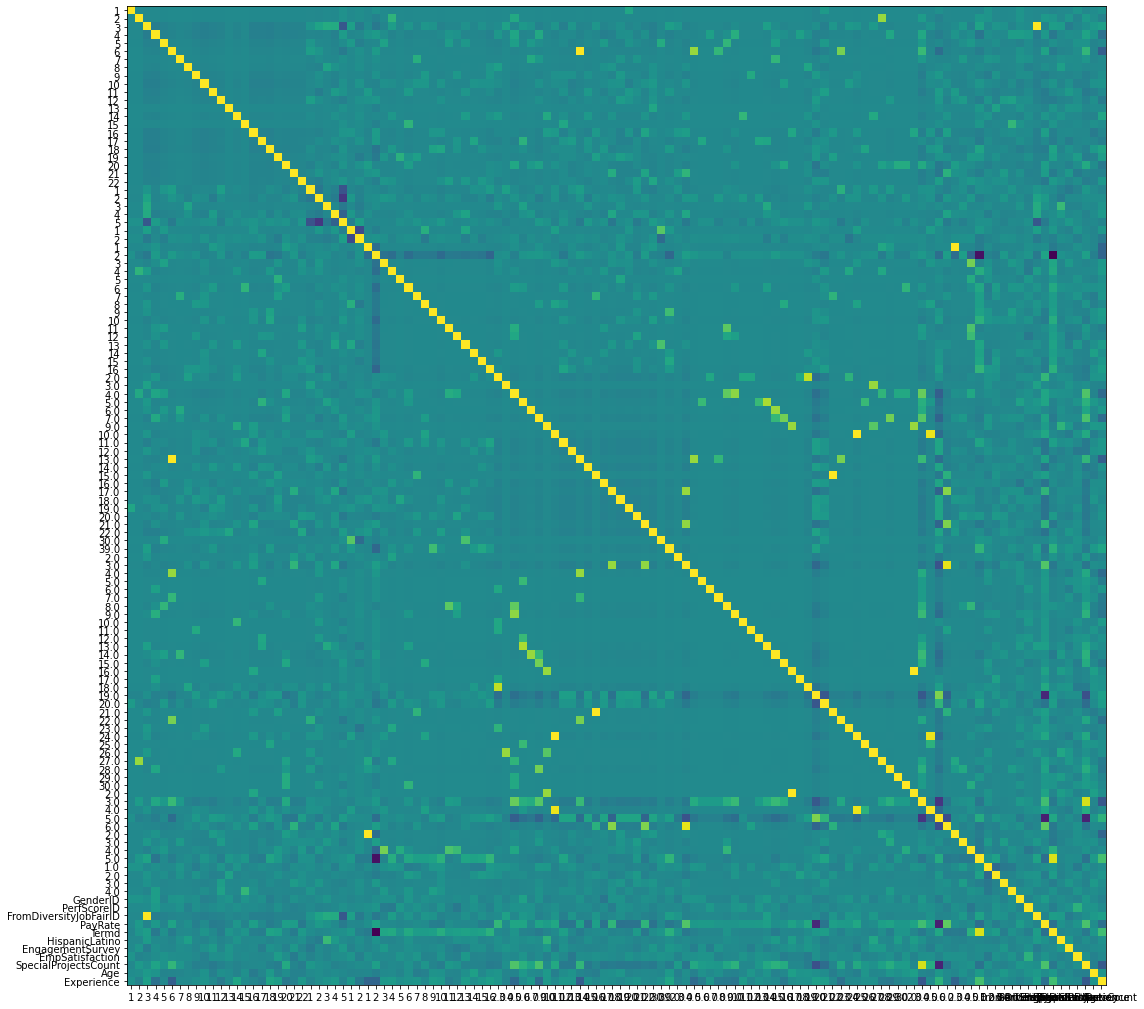

In [ ]:
#@title Columns Correlation Matrix
plt.figure(figsize=(18,18))
plt.subplot(1,1,1)
cols = X.corr().columns
plt.imshow(X.corr())
plt.yticks(np.arange(0, len(cols), 1), cols)
plt.xticks(np.arange(0, len(cols), 1), cols)
plt.show()

In [ ]:
#@title Train Test Split
y = X.pop('PayRate')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [ ]:
#@title Performing standardization before applying PCA
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

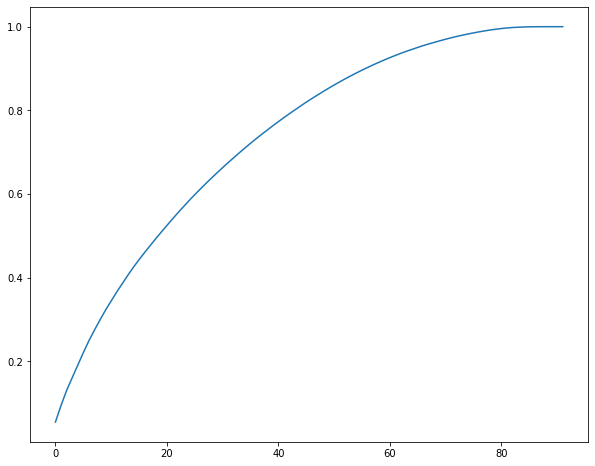

In [ ]:
#@title Dimensionality Reduction Fitting PCA
plt.figure(figsize=(10,8))

pca = PCA(n_components=92)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

plt.plot(np.cumsum(pca.explained_variance_ratio_))

## Training The First Neural Network

In [ ]:
epochs =  50#@param {type:"integer"}
verbose =  2#@param {type:"number"}
mdl_pool = {}
for item in 'Adam','RMSprop','Adadelta','SGD':
    name = 'conv_clf_l2_'+item
    
    inputs = layers.Input(shape=(92))
    l_ = layers.Dense(64,activation='relu')(inputs)
    l_ = layers.Dropout(0.1)(l_)
    l_ = layers.Dense(32,activation='relu',kernel_regularizer=regularizers.l2(1e-5))(l_)
    l_ = layers.Dense(16,activation='relu',kernel_regularizer=regularizers.l2(1e-5))(l_)
    l_ = layers.Dropout(0.3)(l_)
    l_ = layers.Dense(8,activation='linear')(l_)
    output = layers.Dense(1)(l_)
    model = keras.Model(inputs=inputs, outputs=output, name=name)
    model.compile(loss='mse',
            optimizer=item)
    
    mdl_pool[name] = model.fit(x = X_train, y = y_train,
                            batch_size=64, epochs=epochs,
                            verbose=verbose,validation_data=(X_test,y_test),
                            validation_batch_size = 64).history

Epoch 1/50
4/4 - 0s - loss: 1164.8629 - val_loss: 1420.7959
Epoch 2/50
4/4 - 0s - loss: 1132.5559 - val_loss: 1388.1664
Epoch 3/50
4/4 - 0s - loss: 1103.9807 - val_loss: 1356.2253
Epoch 4/50
4/4 - 0s - loss: 1073.6100 - val_loss: 1321.3711
Epoch 5/50
4/4 - 0s - loss: 1044.0262 - val_loss: 1282.0286
Epoch 6/50
4/4 - 0s - loss: 991.3264 - val_loss: 1236.2332
Epoch 7/50
4/4 - 0s - loss: 959.3754 - val_loss: 1181.9977
Epoch 8/50
4/4 - 0s - loss: 904.0460 - val_loss: 1118.0826
Epoch 9/50
4/4 - 0s - loss: 857.9427 - val_loss: 1043.7651
Epoch 10/50
4/4 - 0s - loss: 783.1240 - val_loss: 958.3337
Epoch 11/50
4/4 - 0s - loss: 728.7826 - val_loss: 861.2549
Epoch 12/50
4/4 - 0s - loss: 636.0161 - val_loss: 752.1661
Epoch 13/50
4/4 - 0s - loss: 510.6902 - val_loss: 634.6809
Epoch 14/50
4/4 - 0s - loss: 438.1224 - val_loss: 514.7545
Epoch 15/50
4/4 - 0s - loss: 354.4757 - val_loss: 402.7458
Epoch 16/50
4/4 - 0s - loss: 309.2444 - val_loss: 308.3088
Epoch 17/50
4/4 - 0s - loss: 199.8461 - val_loss: 2

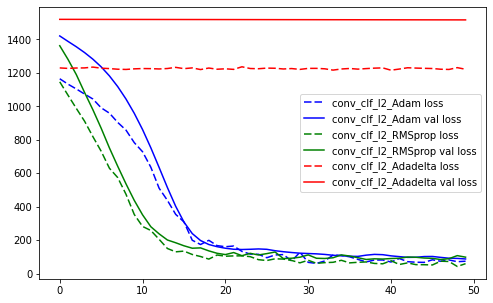

In [ ]:
#@title Plot Training History
plt.figure(figsize=(8,5))
c = ['b', 'g', 'r', 'c']
for i,(name,item) in enumerate(mdl_pool.items()):
    if 'SGD' in name: # sdg produced inf values!
        continue
    plt.plot(item['loss'],linestyle=(0,(5,2)),color=c[i],label = name+' loss')
    plt.plot(item['val_loss'],color=c[i],label = name+' val loss')
plt.legend()